# **AstrID:**  *predictions*

### Importing Necessary Libraries and Modules

In this section, we import the necessary libraries and modules required for validating our model. These include:

- **TensorFlow and Keras**: For loading and using the trained neural network.
- **NumPy**: For numerical operations and handling arrays.
- **Matplotlib**: For plotting and visualizing data.
- **Astropy**: For handling FITS files and WCS data.
- **Custom Functions**: 
    - [`dataGathering`](dataGathering.py): to handle data extraction.
    - [`imageProcessing`](imageProcessing.py): for image modification to fit model requirements.

The comments in the code provide additional details about each import.

In [1]:
import os
import tensorflow as tf
from keras.models import load_model
from keras import backend as K
from keras.initializers import he_uniform

# Import custom model function
from models.unet import unet_model

# Import custom functions to import the dataset
from scripts.dataGathering import importDataset

# Import custom function to preprocess Image and Pixel Mask arrays
from scripts.imageProcessing import normalizeImages, stackImages, stackMasks, preprocessImage
from scripts.imageProcessing import getPredictionComparison, getPredictionOverlay

2024-12-04 16:56:48.602777: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-04 16:56:49.474100: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


2024-12-04 16:56:51.487991: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-12-04 16:56:51.528529: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-12-04 16:56:51.528642: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.


In [3]:
if len(tf.config.list_physical_devices('GPU')) > 0:
    print("GPU is available")
    
    # Clear GPU memory
    K.clear_session()
    tf.config.experimental.reset_memory_stats('GPU:0')

GPU is available


2024-12-04 16:56:51.549382: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-12-04 16:56:51.549568: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-12-04 16:56:51.549637: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-12-04 16:56:51.705138: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-12-04 16:56:51.705242: I tensorflow/compile

### Loading the Dataset

We load the dataset using the `importDataset` function from the `dataGathering` module. This function extracts the images, masks, star data, WCS data, and FITS file names from the specified dataset path.

In [ ]:
# Create images and masks arrays lists
images = []
masks = []
# Create a list of all the wcs data in the dataset folder
wcs_data = []
# Create an array to store the star data inside each fits file
stars_in_image = []
# Create a list of all the fits files in the dataset folder
fits_files = []
# Define the path to the dataset
dataset_path = 'data/fits/validate/'

# Import the dataset
images, masks, stars_in_image, wcs_data, fits_files = importDataset(dataset_path=dataset_path)

Number of stars in catalog query:  569
validate3.fits added to dataset
Number of stars in catalog query:  819
validate17.fits added to dataset
Number of stars in catalog query:  2296
validate12.fits added to dataset
Number of stars in catalog query:  566
validate16.fits added to dataset
Number of stars in catalog query:  487
validate18.fits added to dataset
Number of stars in catalog query:  642
validate10.fits added to dataset
Number of stars in catalog query:  1708
validate19.fits added to dataset
Number of stars in catalog query:  511
validate13.fits added to dataset
Number of stars in catalog query:  859
validate15.fits added to dataset
Number of stars in catalog query:  1310
validate4.fits added to dataset
Number of stars in catalog query:  621
validate7.fits added to dataset
Number of stars in catalog query:  595
validate11.fits added to dataset
Number of stars in catalog query:  620
validate14.fits added to dataset
Number of stars in catalog query:  4489
validate0.fits added to 

### Preparing Images and Masks for the Model

To ensure our images and masks are in the correct format for validation, we need to perform some transformations. Our model expects the images to have three channels, similar to standard RGB images, and the masks to have a single channel. Here’s how we achieve this:

**Convert Images to 3-Channel Format:** Our images are currently in the shape `(512, 512)`, but the model requires them to be in the shape `(512, 512, 3)`. To convert the single-channel images into 3-channel images, we stack the images along the last axis three times. This transformation is necessary because the model typically expects 3-channel input images.

**Convert Masks to Single-Channel Format:** For the masks, the model expects them to be in the shape `(512, 512, 1)`. We expand the masks along the last axis to add a new dimension, ensuring they have the correct shape.

**Convert to NumPy Arrays:** Both the images and masks need to be converted to NumPy arrays, as this is the desired format for the validation model. This conversion ensures that the data is in the correct format for validation.

Below, we perform these conversions to ensure the data is in the correct format for validation.

In [5]:
test_images = stackImages(images)
test_masks = stackMasks(masks)

### Normalizing the Images

To standardize the pixel values in our images, we need to normalize them to a common range. We will use min-max normalization to scale the pixel values to a range between 0.0 and 1.0.

In [6]:
# test_images = normalizeImages(test_images)

### Choose the Correct Model

We display models in the saved models directory. The most recent model is chosen to load, if you train and save a new model ensure it is listed as the `model_choice`.

In [7]:
# Display all the models in the models folder
saved_models_path = 'models/saved_models/'
model_weights = os.listdir(saved_models_path)
model_weights = [file for file in model_weights if file.endswith('.h5')]
model_weights = sorted(model_weights)
model_weights


['2024_12_04-0020_16_unet_model_chris.keras_weights.h5',
 '2024_12_04-0027_16_unet_model_chris.keras_weights.h5',
 '2024_12_04-0236_16_unet_model_chris.keras_weights.h5']

In [8]:
# Pick the most recent model
model_choice = model_weights[-1]

In [9]:
#List your model choice to load for verification
model_choice

'2024_12_04-0236_16_unet_model_chris.keras_weights.h5'

### Loading the Trained Model

In this section, we first define the hyperparameters that were used to train the model. Using these hyperparameters, we compile an instance of our U-Net model. 

Once the model architecture is defined and compiled, we load the pre-trained weights into this model instance. This allows us to use the trained model to make predictions on the test dataset. By loading the weights separately, we ensure that the model retains the learned parameters from the training phase, enabling accurate predictions on new data.



In [10]:
# Input shape for the model is the shape of the stacked images
input_shape = test_images.shape[1:]
input_shape

(1024, 1024, 3)

In [11]:
# Define hyperparameters
hyperparameters = {
    'input_shape': input_shape,
    'filters': [64, 128, 256, 512, 1024],
    'kernel_size': (3, 3),
    'activation': 'relu',
    'padding': 'same',
    'initializer': he_uniform
}

# Create and compile the model using hyperparameters
model = unet_model(
    input_shape=hyperparameters['input_shape'],
    filters=hyperparameters['filters'],
    kernel_size=hyperparameters['kernel_size'],
    activation=hyperparameters['activation'],
    padding=hyperparameters['padding'],
    initializer=hyperparameters['initializer']
)

# Load the saved model weights
model.load_weights(saved_models_path + model_choice)

### Visualizing Results

We visualize the results by plotting the original images, ground truth masks, and predicted masks. This helps us understand how well the model is performing.

Number of stars in catalog query:  569


2024-12-04 16:56:56.517152: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600


1/1 [==============================] - 2s 2s/step


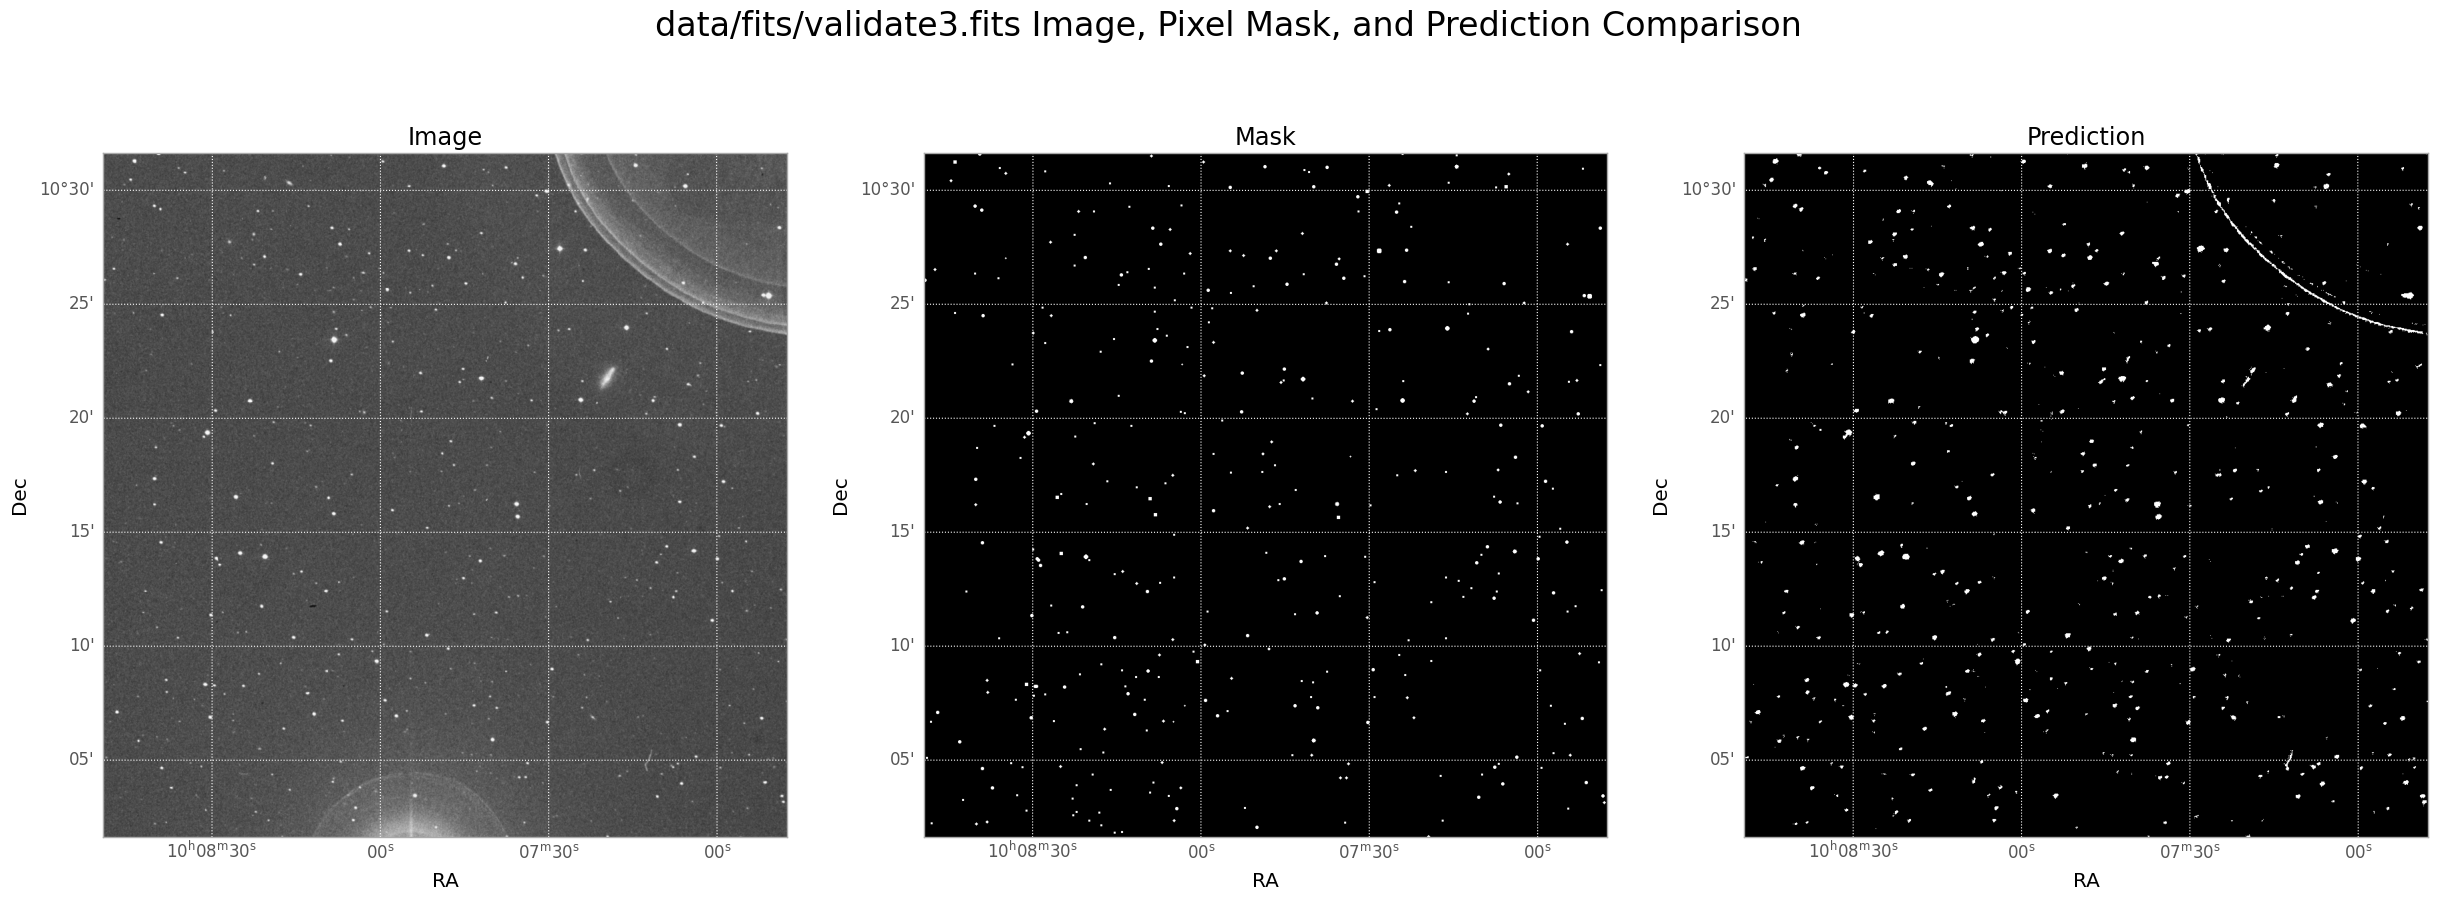

Number of stars in catalog query:  569
1/1 [==============================] - 0s 25ms/step
Number of stars detected: 11124


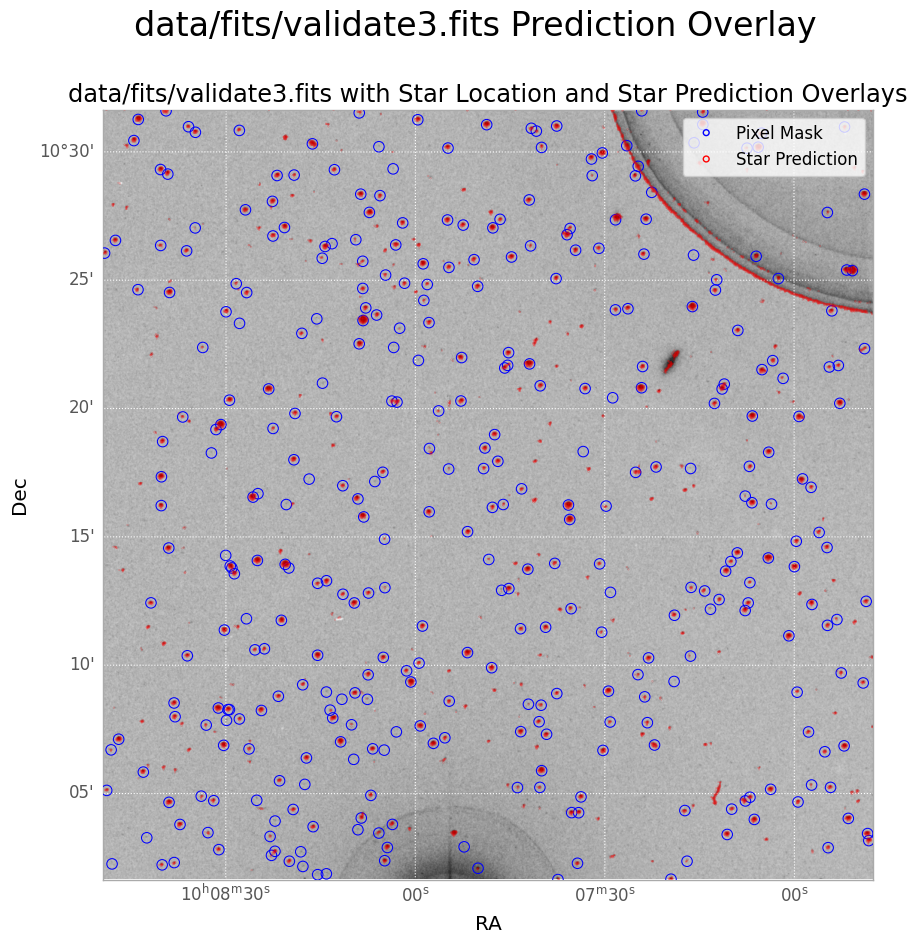

Number of stars in catalog query:  819
1/1 [==============================] - 0s 30ms/step


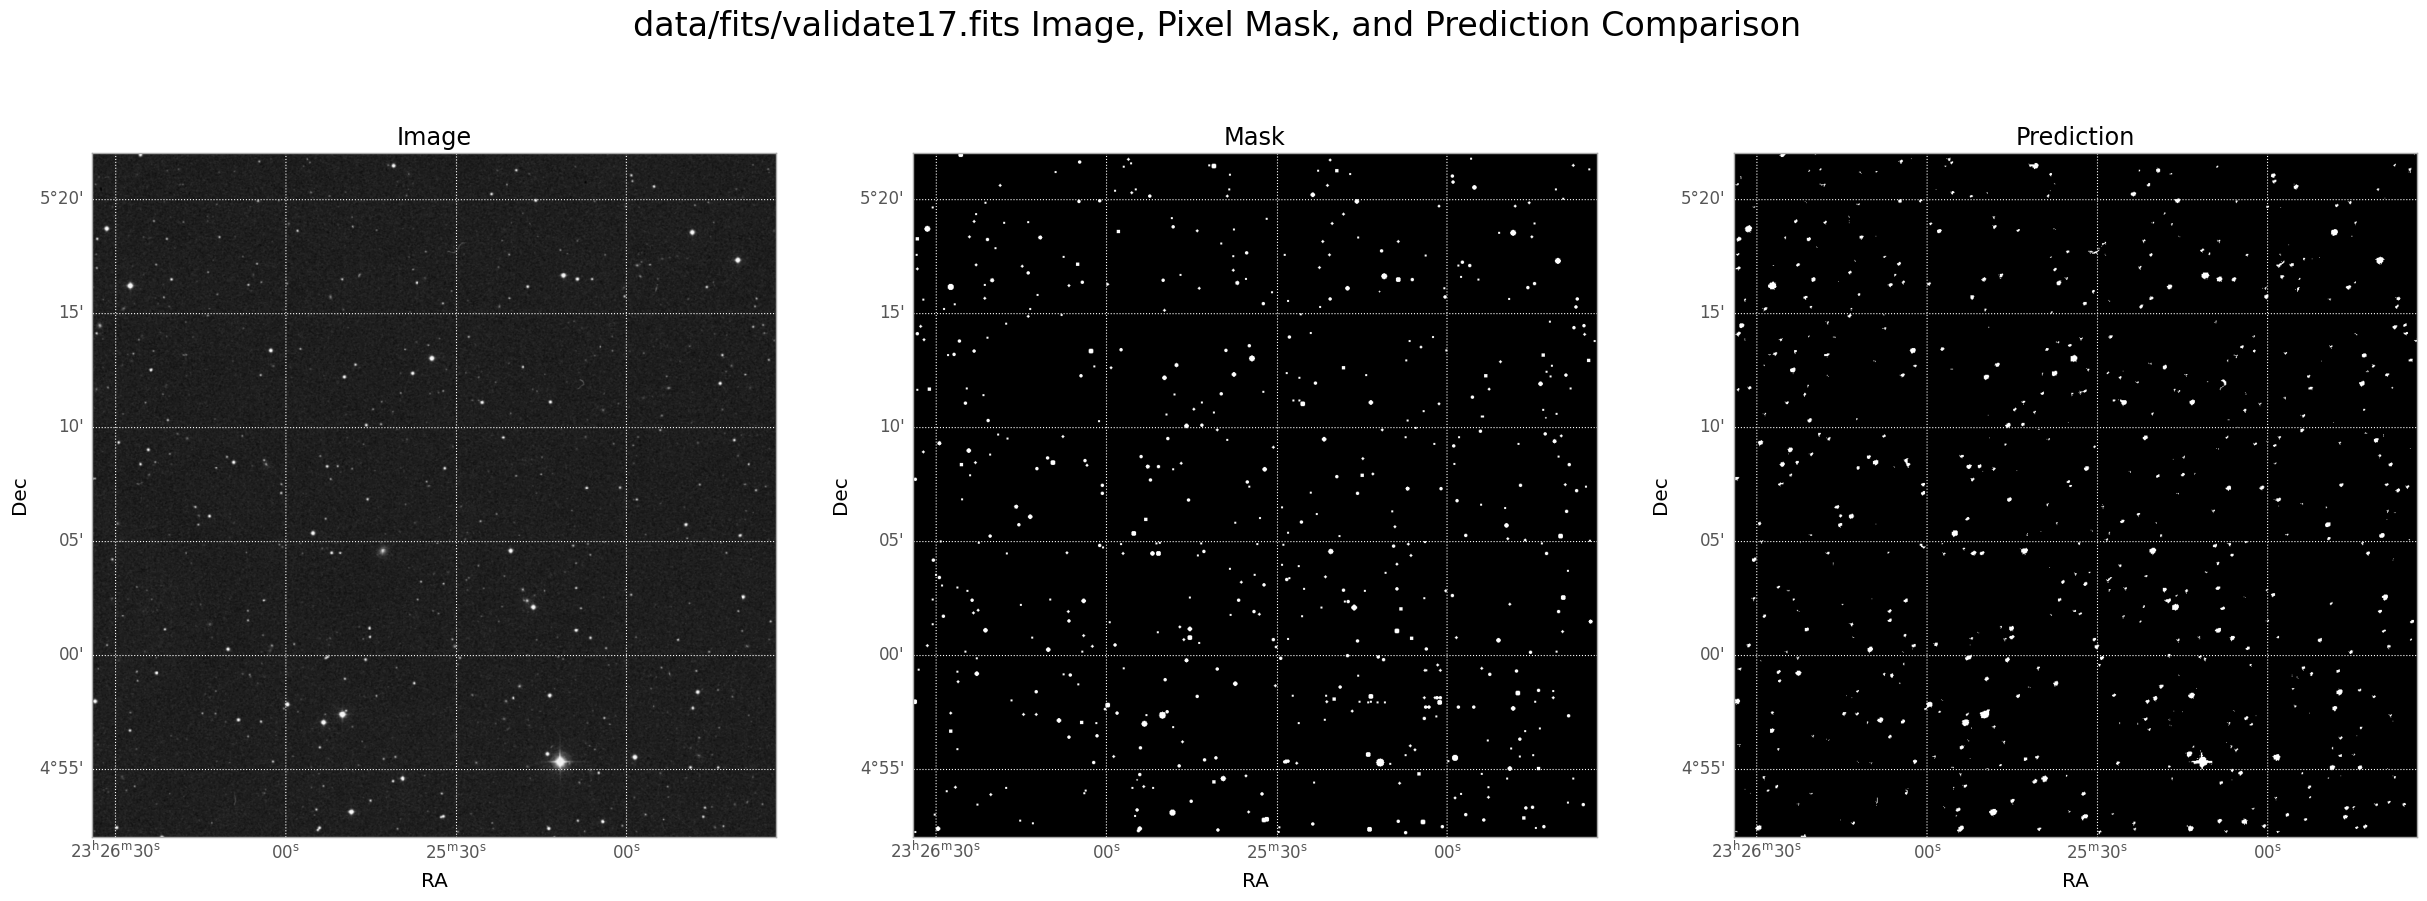

Number of stars in catalog query:  819
1/1 [==============================] - 0s 24ms/step
Number of stars detected: 11137


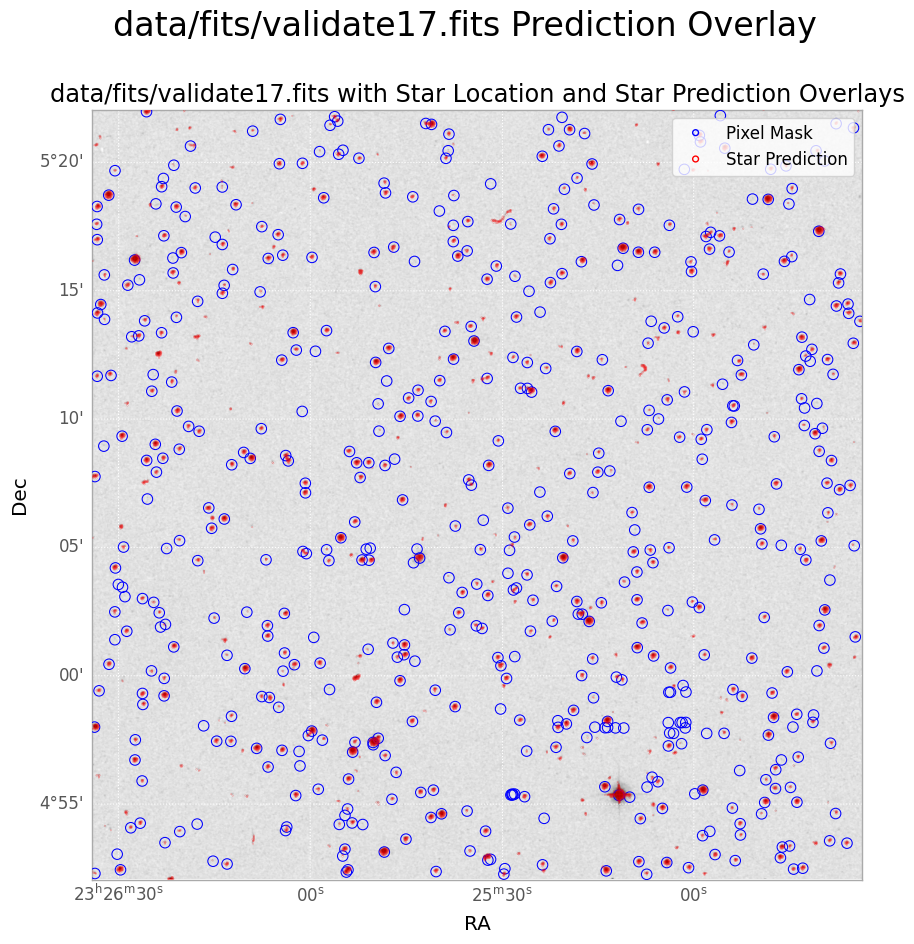

Number of stars in catalog query:  2296
1/1 [==============================] - 0s 27ms/step


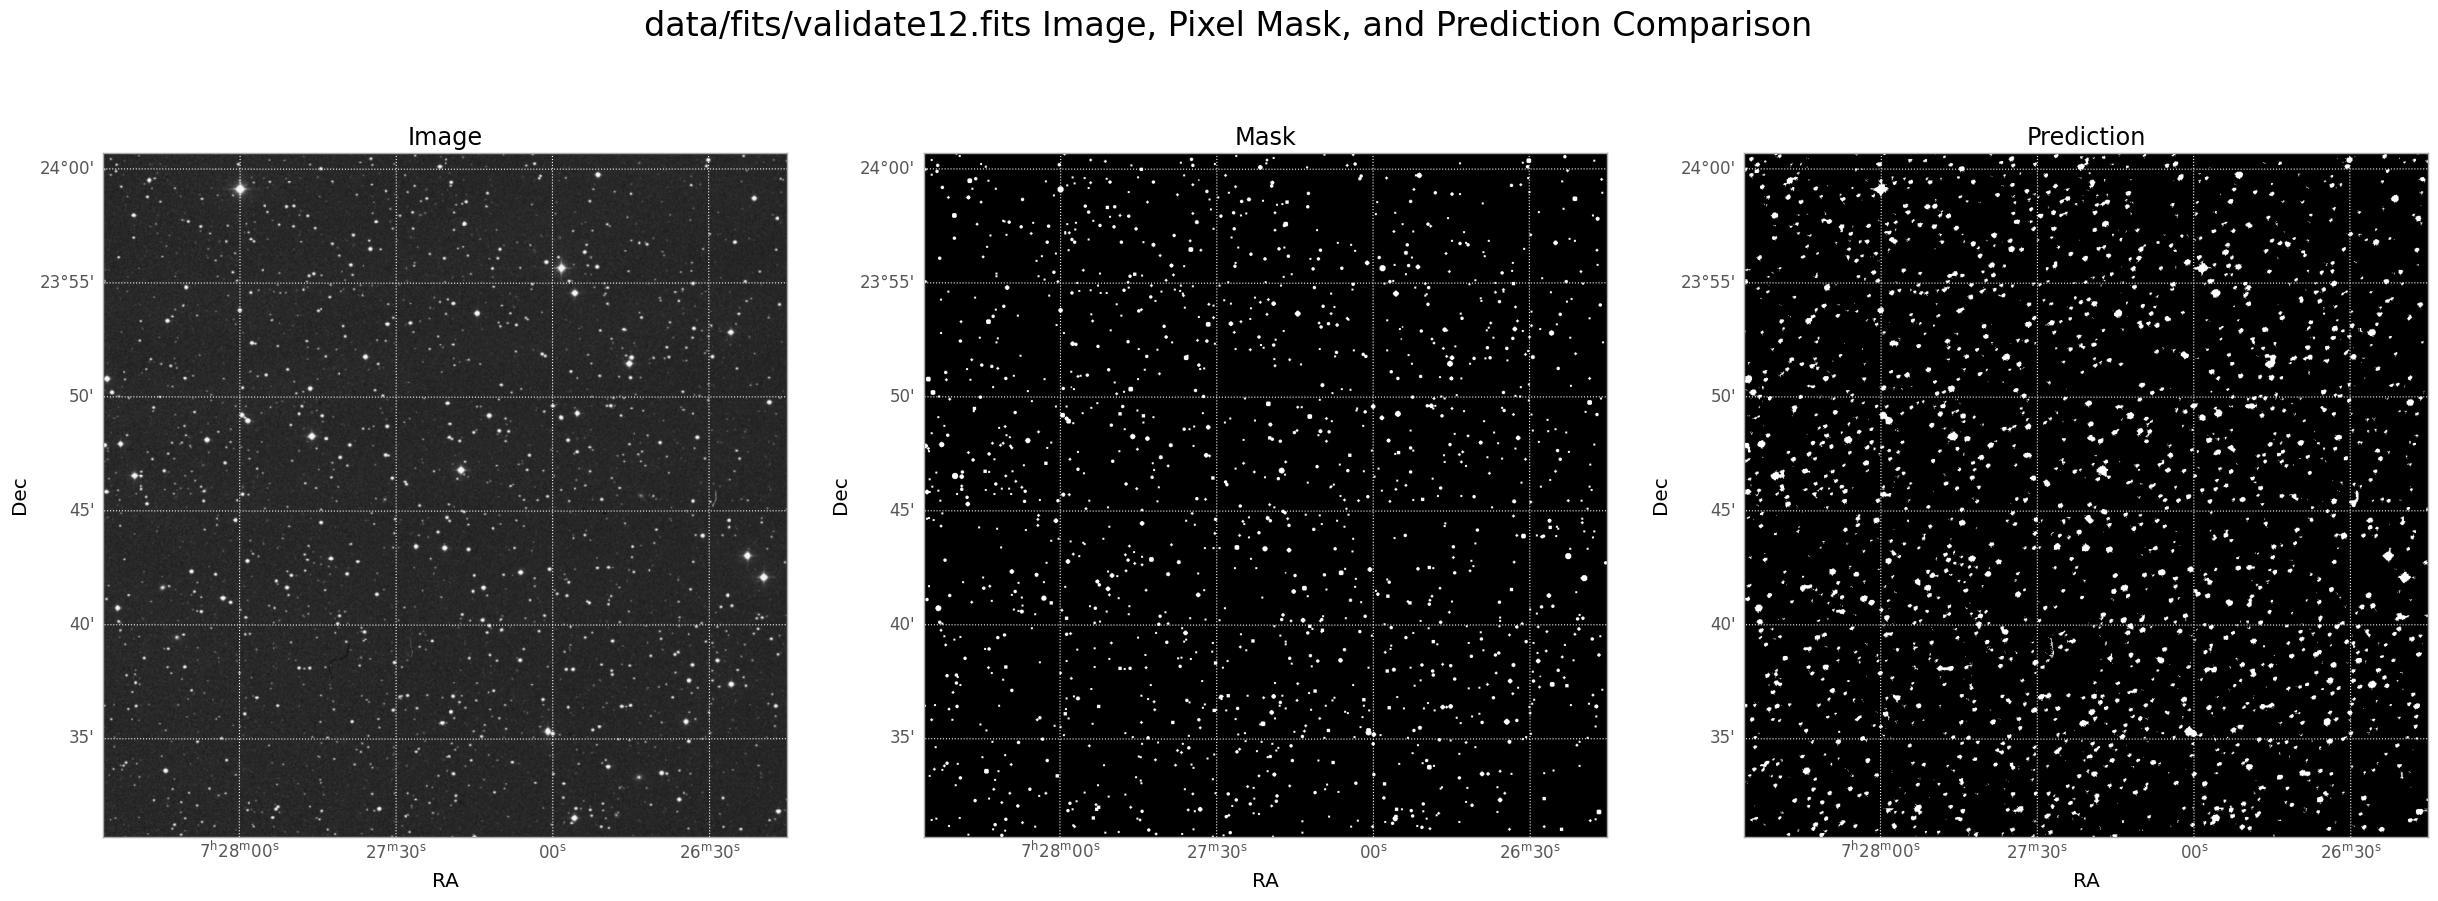

Number of stars in catalog query:  2296
1/1 [==============================] - 0s 26ms/step
Number of stars detected: 48243


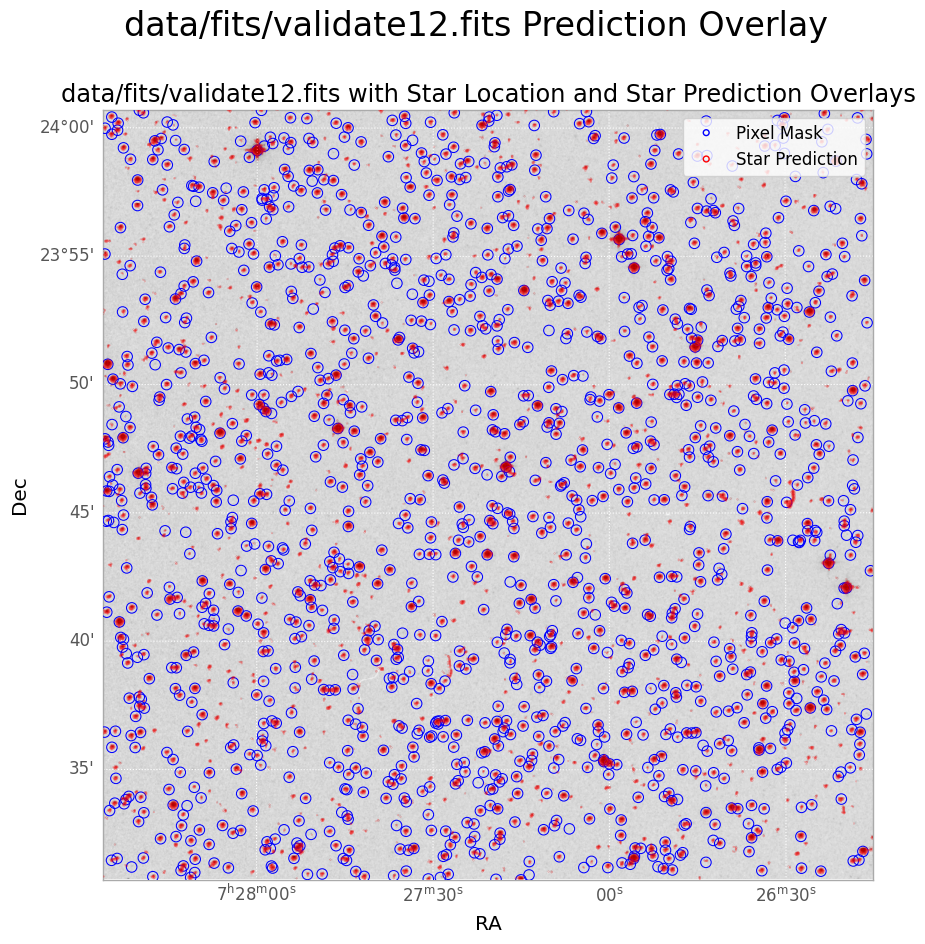

Number of stars in catalog query:  566
1/1 [==============================] - 0s 42ms/step


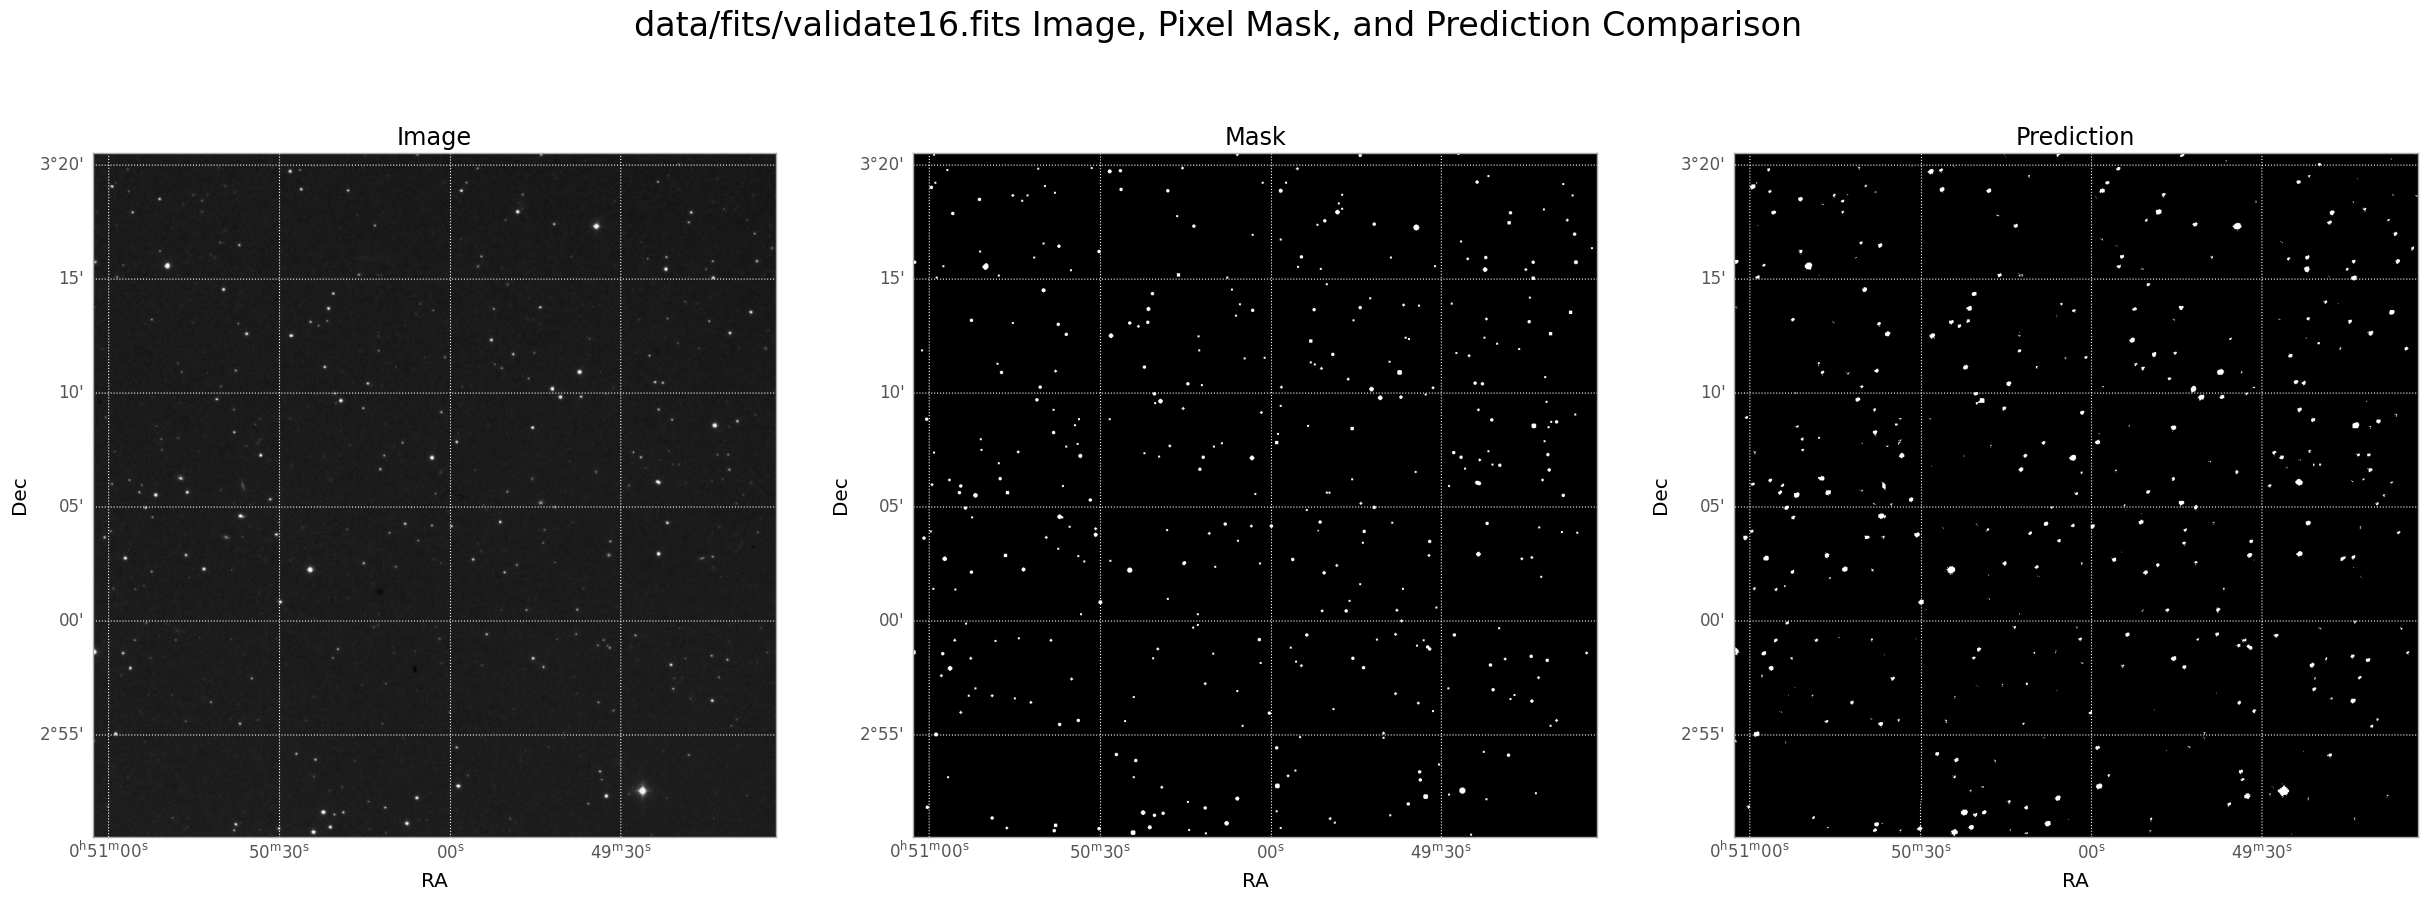

Number of stars in catalog query:  566
1/1 [==============================] - 0s 36ms/step
Number of stars detected: 8089


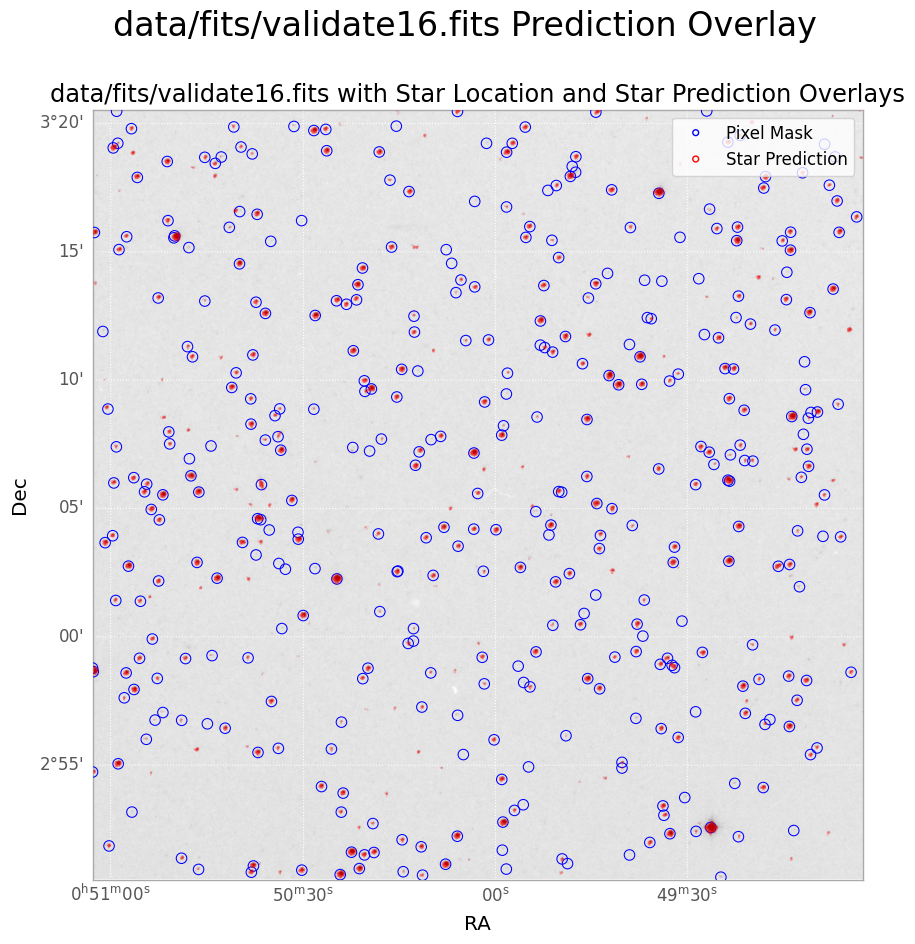

In [12]:
# Plot the results from the model
for fits_file in fits_files[0:4]:
    getPredictionComparison(fits_file, model, threshold=0.5)
    getPredictionOverlay(fits_file, model, threshold=0.5, cmap='gray_r')

### Making Predictions

We use the trained model to make predictions on the test dataset. The predictions are compared with the ground truth masks to evaluate the model's performance.

In [16]:
# Reduce batch size
batch_size = 1

predictions = model.predict(test_images, batch_size=batch_size, verbose=1)

20/20 [==============================] - 1s 65ms/step


### Evaluating the Model

We evaluate the model's performance on the test dataset. We calculate the loss and accuracy metrics to assess the model's effectiveness.

In [18]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Evaluate the model on the test data
loss, accuracy = model.evaluate(test_images, test_masks, batch_size=batch_size, verbose=1)
print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')

20/20 [==============================] - 2s 75ms/step - loss: 0.0690 - accuracy: 0.9722
Test Loss: 0.06900330632925034
Test Accuracy: 0.9722496271133423


### Saving Results

We save the results, including the original images, ground truth masks, and predicted masks, to the results directory. This allows us to review and analyze the model's performance later.

In [ ]:
# # Iterate over the test set and save the image with overlayed mask and prediction to a file
for fits_file in fits_files:
    getPredictionComparison(fits_file, model, threshold=0.5, save_prediction=True)
    getPredictionOverlay(fits_file, model, threshold=0.5, cmap='gray_r', save_prediction=True)